In [1]:
from functools import partial
import os
from pathlib import Path
import numpy as np
import torch
from torch import nn
from tqdm import tqdm

from src import multitask_datamod, multitask_model
from src.constants import weights
from src.multitask_lit import LitMultitask

from matplotlib import patches, pyplot as plt


class Model(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)


device = "cuda"
PROJECT_DIR = "/mnt/c/Users/piotr.hondra/Documents/inz/indoor-semantic-segmentation"
DATASET_PATH = os.path.join(PROJECT_DIR, "datasets")
dataloader_params = {"batch_size": 8, "pin_memory": False}
data_module = multitask_datamod.MultitaskDataModule(DATASET_PATH, dataloader_params)

data_module.setup("test")
test_loader = data_module.test_dataloader()
test_set_filenames = data_module.test_set.filenames_df.values.flatten()
mlt_model = multitask_model.MultitaskNet()
colormap = {
    255: (0,0,0),
    1: (0, 0, 255),
    2: (232, 88, 47),
    3: (0, 217, 0),
    4: (148, 0, 240),
    5: (222, 241, 23),
    6: (255, 205, 205),
    7: (0, 223, 228),
    8: (106, 135, 204),
    9: (116, 28, 41),
    10: (240, 35, 235),
    11: (0, 166, 156),
    12: (249, 139, 0),
    0: (225, 228, 194),
}

# colormap_gt = {
#     0: (0,0,0),
#     1: (0, 0, 255),
#     2: (232, 88, 47),
#     3: (0, 217, 0),
#     4: (148, 0, 240),
#     5: (222, 241, 23),
#     6: (255, 205, 205),
#     7: (0, 223, 228),
#     8: (106, 135, 204),
#     9: (116, 28, 41),
#     10: (240, 35, 235),
#     11: (0, 166, 156),
#     12: (249, 139, 0),
#     13: (225, 228, 194),
# }

NYU_V2_segmentation_13classes = [
    "void",
    "bed",
    "books",
    "ceiling",
    "chair",
    "floor",
    "furniture",
    "objects",
    "picture",
    "sofa",
    "table",
    "tv",
    "wall",
    "window",
]
handles = [patches.Patch(color=list(map(lambda x: x/255, color)), label=label) for color, label in zip(colormap.values(), NYU_V2_segmentation_13classes)]
def to_rgb(x, colormap):
    to_rgb = np.vectorize(
        lambda x: tuple(colormap[int(x)]) 
    )
    return to_rgb(x)
# to_rgb = partial(to_rgb, colormap=colormap)

other_indoor|kitchen|bedroom|living_room|bathroom|office|dining_room


In [2]:



model = Model(mlt_model).to(device)
# checkpoint = torch.load("logs_to_convert/segmentation_only/lr-1.268e-04/checkpoints/epoch=4-step=500.ckpt")
checkpoint = torch.load("logs_to_convert/multitask_simple/lr-9.160e-05/checkpoints/epoch=5-step=600.ckpt")
# checkpoint = torch.load("logs_to_convert/fine_tuning/lr_init-1.63e-04-lr_backbone-2.88e-07/checkpoints/epoch=3-step=400.ckpt")
model.load_state_dict(checkpoint["state_dict"], strict=False)

masks_preds = []
masks_targets_p = []
scene_targets_p = []
scene_p = []
with torch.no_grad():
    model.eval()
    for batch in tqdm(test_loader):
        rgb, mask_targets, scene_targets = map(lambda x: x.to(device), batch)
        mask_preds, scene_preds = model(rgb)
        mask_targets = mask_targets.cpu().detach()
        mask_preds= torch.argmax(mask_preds.cpu().detach(), dim=1)
        scene_targets = scene_targets.cpu().detach()
        scene_preds = torch.argmax(scene_preds.cpu().detach(), dim=1)

        # masks_preds.append(mask_preds)
        # masks_targets_p.append(mask_targets)
        scene_targets_p.append(scene_targets)
        scene_p.append(scene_preds)
        # x = scene_preds.argmax(dim=1)
        # x = mask_preds.argmax(dim=1)
        # print(x[0])
        # im = to_rgb(mask_targets[3].cpu(), colormap)
        # print(im[2].shape)
        # plt.figure(figsize=(20, 15))
        # plt.subplot(121)
        # plt.imshow(rgb[3].permute(1,2,0).cpu())
        # plt.imshow(np.moveaxis(np.stack(im),0,2), alpha=0.75)
        # plt.axis("off")
        # # Creating legend with color box 

        

        # # pop_a = patches.Patch(color=(1,1,1), label='Population Dataset 1') 
        # # pop_b = patches.Patch(color='#CE5D45', label='Population Dataset 2') 
        # # plt.legend() 
        # plt.subplot(122)
        # im = to_rgb(x[3].cpu(), colormap)
        # # print(im[2].shape)
        
        # plt.imshow(rgb[3].permute(1,2,0).cpu())
        # plt.imshow(np.moveaxis(np.stack(im),0,2), alpha=0.75)
        # plt.axis("off")
        # plt.legend(handles=handles, bbox_to_anchor=(1.04, 1), loc="upper left")
        # plt.show()
        # break



100%|██████████| 66/66 [00:34<00:00,  1.94it/s]


In [3]:
# masks_full = torch.vstack(masks_preds)
# mask_targets_full = torch.vstack(masks_targets_p
scene_targets_full = torch.hstack(scene_targets_p)
scene_preds_full = torch.hstack(scene_p)
# scene_p

In [ ]:
torch.unique(scene_targets_full)

In [4]:
SCENE_MERGED_IDS = {
    "other_indoor": 0,
    "kitchen": 1,
    "bedroom": 2,
    "living_room": 3,
    "bathroom": 4,
    "office": 5,
    "dining_room": 6,
}
i = SCENE_MERGED_IDS["other_indoor"]
indices = (scene_targets_full==i).nonzero().squeeze().tolist()

In [6]:
import random
from PIL import Image
root = "/mnt/c/Users/piotr.hondra/Documents/inz/indoor-semantic-segmentation/datasets/test/rgb"


In [ ]:

samples = random.sample(indices,3)
for sample_idx in samples:
    path = os.path.join(root, f"{test_set_filenames[sample_idx]}.png")
    rgb = Image.open(path)
    plt.figure(figsize=(20, 15), dpi=150)

    plt.subplot(131)
    plt.axis("off")
    plt.imshow(rgb)
    
    plt.subplot(132)
    plt.axis("off")
    plt.imshow(rgb)
    im = to_rgb(masks_full[sample_idx], colormap)
    plt.imshow(np.moveaxis(np.stack(im),0,2), alpha=0.75)
    plt.subplot(133)
    plt.axis("off")
    plt.imshow(rgb)
    im = to_rgb(mask_targets_full[sample_idx], colormap)
    plt.imshow(np.moveaxis(np.stack(im),0,2), alpha=0.75)
    # plt.axis("off")
    # # Creating legend with color box 

    

    # # pop_a = patches.Patch(color=(1,1,1), label='Population Dataset 1') 
    # # pop_b = patches.Patch(color='#CE5D45', label='Population Dataset 2') 
    # # plt.legend() 
    # plt.subplot(122)
    # im = to_rgb(x[3].cpu(), colormap)
    # # print(im[2].shape)
    
    # plt.imshow(rgb[3].permute(1,2,0).cpu())
    # plt.imshow(np.moveaxis(np.stack(im),0,2), alpha=0.75)
    plt.legend(handles=handles, bbox_to_anchor=(1.04, 1), loc="upper left")
    print()
    # plt.show()
    # break

In [17]:
from torchvision.io import read_image
name = "bedroom"
i = SCENE_MERGED_IDS[name]
scene_indices = (
    torch.logical_and(
        (scene_preds_full != scene_targets_full), (scene_preds_full == i)
    )
    .nonzero()
    .squeeze()
)
imgs = []
for ind in scene_indices:
    path = os.path.join(root, f"{test_set_filenames[ind]}.png")
    rgb = read_image(path)
    # rgb = isns.load_image(path)
    imgs.append(rgb)
# g = isns.ImageGrid(cells, col_wrap=5, cbar=False)


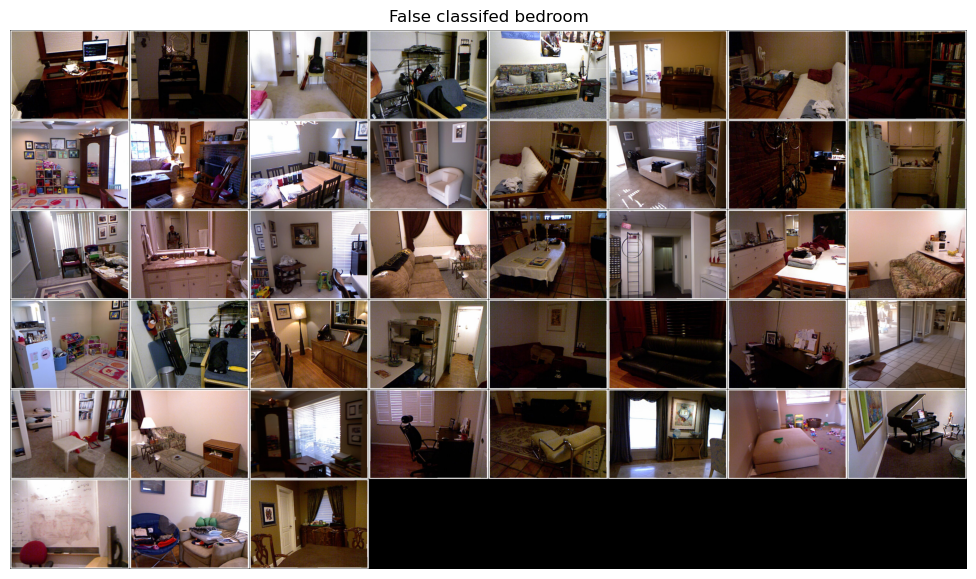

In [28]:
import torchvision
from torchvision.utils import make_grid
import torch

# Create a list of tensors representing images
# images = [torch.rand(3, 32, 32) for _ in range(10)]

# Create a grid of images
grid = make_grid(imgs)# imgs[0].shape
# x = np.stack(imgs)
# print(x)
plt.figure(figsize=(15,7))
plt.title(f"Wrongly classifed {name.replace('_', ' ')} class")
img = torchvision.transforms.ToPILImage()(grid)
plt.axis("off")
plt.imshow(img)



In [16]:
torch.unique(scene_targets_full[scene_indices], return_counts=True)

(tensor([0, 1, 3, 4, 5, 6]), tensor([ 5,  1, 22,  1,  7,  7]))